In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
from scipy.stats import median_abs_deviation

#pd.options.display.float_format = '{:.2f}'.format

from model_SARIMA import *
from model_naiv import *
from test_mean import *
from test_correlation import *
from cross_validation import *

warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

actual_values_dict = {}

for store in range(1, 46):
    store_df = df[df['store'] == store].copy()
    store_df.sort_values('date', inplace=True)
    store_df.set_index('date', inplace=True)

    actual_values_dict[store] = store_df['weekly_sales']

Modell wählen

In [3]:
#model_type = 'SARIMA'
#model_type = 'Naive'
model_type = 'Additive'

Alle Residuen und Fitted Values berechnen

In [4]:
fitted_values_dict = {}
residuals_dict = {}

if model_type == 'Naive':
    residuals_dict, fitted_values_dict = naive_for_all_stores('Walmart_Sales.csv')

if model_type == 'Additive':
    residuals_dict, fitted_values_dict, y_train_dict, y_test_dict = additive_for_all_stores('Walmart_Sales.csv', sample = 'IS')
    errors_dict, forecast_dict, y_train_dict, y_test_dict = additive_for_all_stores('Walmart_Sales.csv', sample = 'OOS')

if model_type == 'SARIMA':
    sarima_models = SARIMA_for_all_stores('Walmart_Sales.csv', whichorder = 5)


In [5]:
if model_type == 'SARIMA':
    for store in range(1, 46):
        model = sarima_models.get(store)
        fitted_values_dict[store] = model.fittedvalues.iloc[52:] # erste 52 Werte entfernen
        residuals_dict[store] = model.resid.iloc[52:] # erste 52 Werte entfernen


#pd.set_option('display.max_rows', None)
print(len(errors_dict[1]))
#print(residuals_dict[1])
print(len(residuals_dict[1]))
#print(len(fitted_values_dict[1]))

43
99


Residuen

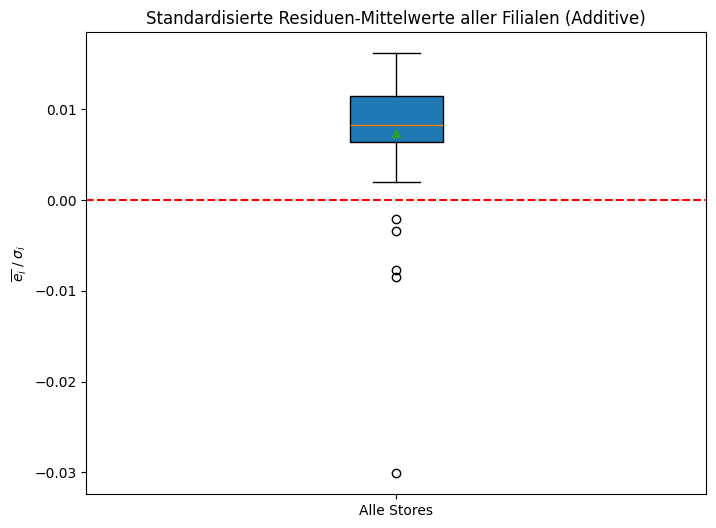

[0.008154904964496442, 0.005194927305058506, 0.0064004588466191024, 0.00871673911635864, 0.013835870044605555, 0.00683958019450436, 0.011441017238919212, 0.00789691341812474, 0.014347969263546147, 0.00803811700363059, 0.011137289951741559, 0.014854209154550614, 0.011319375036614966, 0.008153213703888908, 0.0048794057331752036, 0.012844295956666318, 0.011573488842746137, 0.006676152583262509, 0.006472671812765129, 0.008392013668456693, 0.009858297243282828, 0.012605014713158176, 0.0019436819436496485, 0.008405374507131455, 0.006289165730476905, 0.008275777667685226, 0.007426109527647773, 0.008672119349068834, 0.008240537139433915, -0.008507866719492468, 0.011464140277216518, 0.01084030886691117, -0.002114951498093073, 0.0059126309140266, 0.0161536560252323, -0.030091730477923986, -0.0033909157399523633, 0.01477248687771083, 0.01573715519373129, 0.007805665007442603, 0.01454349063851084, 0.005442465078916672, -0.007754068363713059, 0.010373378956563331, 0.013026851083940933]
Mittelwert: 

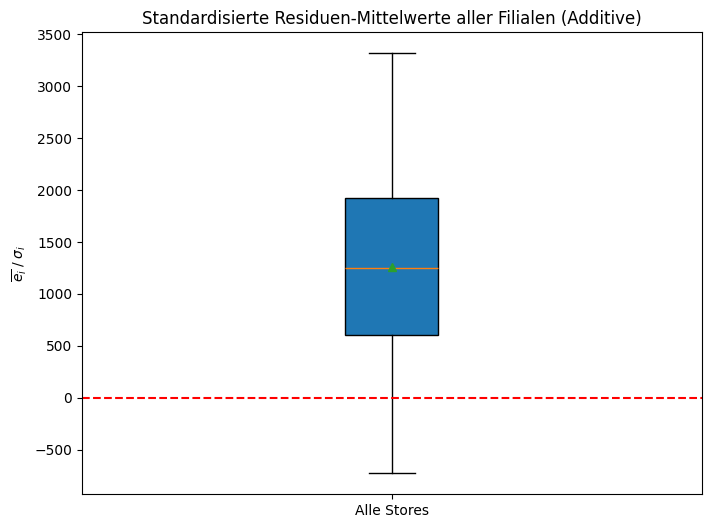

In [6]:
resid_bias = [] 
for store in sorted(residuals_dict.keys(), key=int):
    resid = residuals_dict[store]
    mean = resid.mean()
    std = resid.std(ddof=0)        # Populations-Std (ddof=0)
    if std == 0:
        resid_bias.append(np.nan)
    else:
        resid_bias.append(mean / std) # standardisierter Bias

# Erstelle den Boxplot der Mittelwerte
plt.figure(figsize=(8, 6))
plt.boxplot(resid_bias, patch_artist=True, showmeans=True)
plt.title('Standardisierte Residuen-Mittelwerte aller Filialen ({})'.format(model_type))
plt.ylabel(r'$\overline{e_i}\; / \;\sigma_i$')
plt.xticks([1], ["Alle Stores"])
plt.axhline(0, color = 'red',ls='--')
plt.show()

print(resid_bias)
print("Mittelwert: ", np.mean(resid_bias))
print("Median: ", np.median(resid_bias))


# Normale Mittelwerte
resid_means = [] 
for store in sorted(residuals_dict.keys(), key=int):
    resid_mean = residuals_dict[store].mean()

    resid_means.append(resid_mean)

plt.figure(figsize=(8, 6))
plt.boxplot(resid_means, patch_artist=True, showmeans=True)
plt.title('Standardisierte Residuen-Mittelwerte aller Filialen ({})'.format(model_type))
plt.ylabel(r'$\overline{e_i}\; / \;\sigma_i$')
plt.xticks([1], ["Alle Stores"])
plt.axhline(0, color ='red', ls='--')
plt.show()

Korrelations Tests

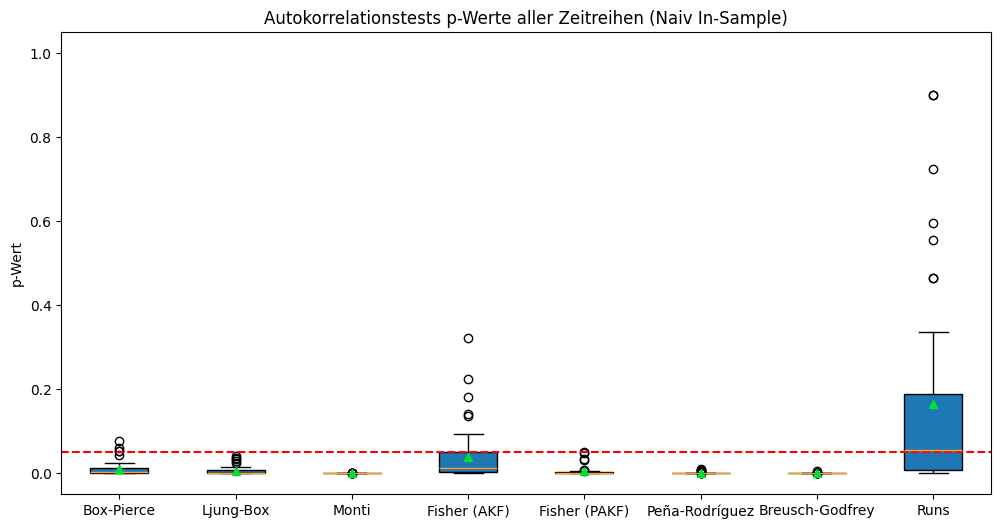

BOX-PIERCE Mittelwert: 0.009933150416507774 Median: 0.0013660926288550411 Standardabweichung: 0.018081513060421824 Annahme (%): 8.88888888888889
LJUNG-BOX Mittelwert: 0.005342288414443298 Median: 0.00041565771924148684 Standardabweichung: 0.010073062044385331 Annahme (%): 0.0
MONTI Mittelwert: 1.047147321891669e-05 Median: 6.679495812011993e-08 Standardabweichung: 3.4046450053210396e-05 Annahme (%): 0.0
FISHER (AKF) Mittelwert: 0.03873140492054233 Median: 0.012041653447658063 Standardabweichung: 0.06647659528391178 Annahme (%): 22.22222222222222
FISHER (PAKF) Mittelwert: 0.00426483621671327 Median: 0.00026802633744493765 Standardabweichung: 0.011750042500757615 Annahme (%): 2.2222222222222223
PEÑA-RODRIGUEZ Mittelwert: 0.0006607550386142938 Median: 2.3297102110131362e-05 Standardabweichung: 0.0020229692328474947 Annahme (%): 0.0
BREUSCH-GODFREY Mittelwert: 0.00011676202148331517 Median: 2.2447083998502468e-08 Standardabweichung: 0.0007343832282668806 Annahme (%): 0.0
RUNS Mittelwert: 0

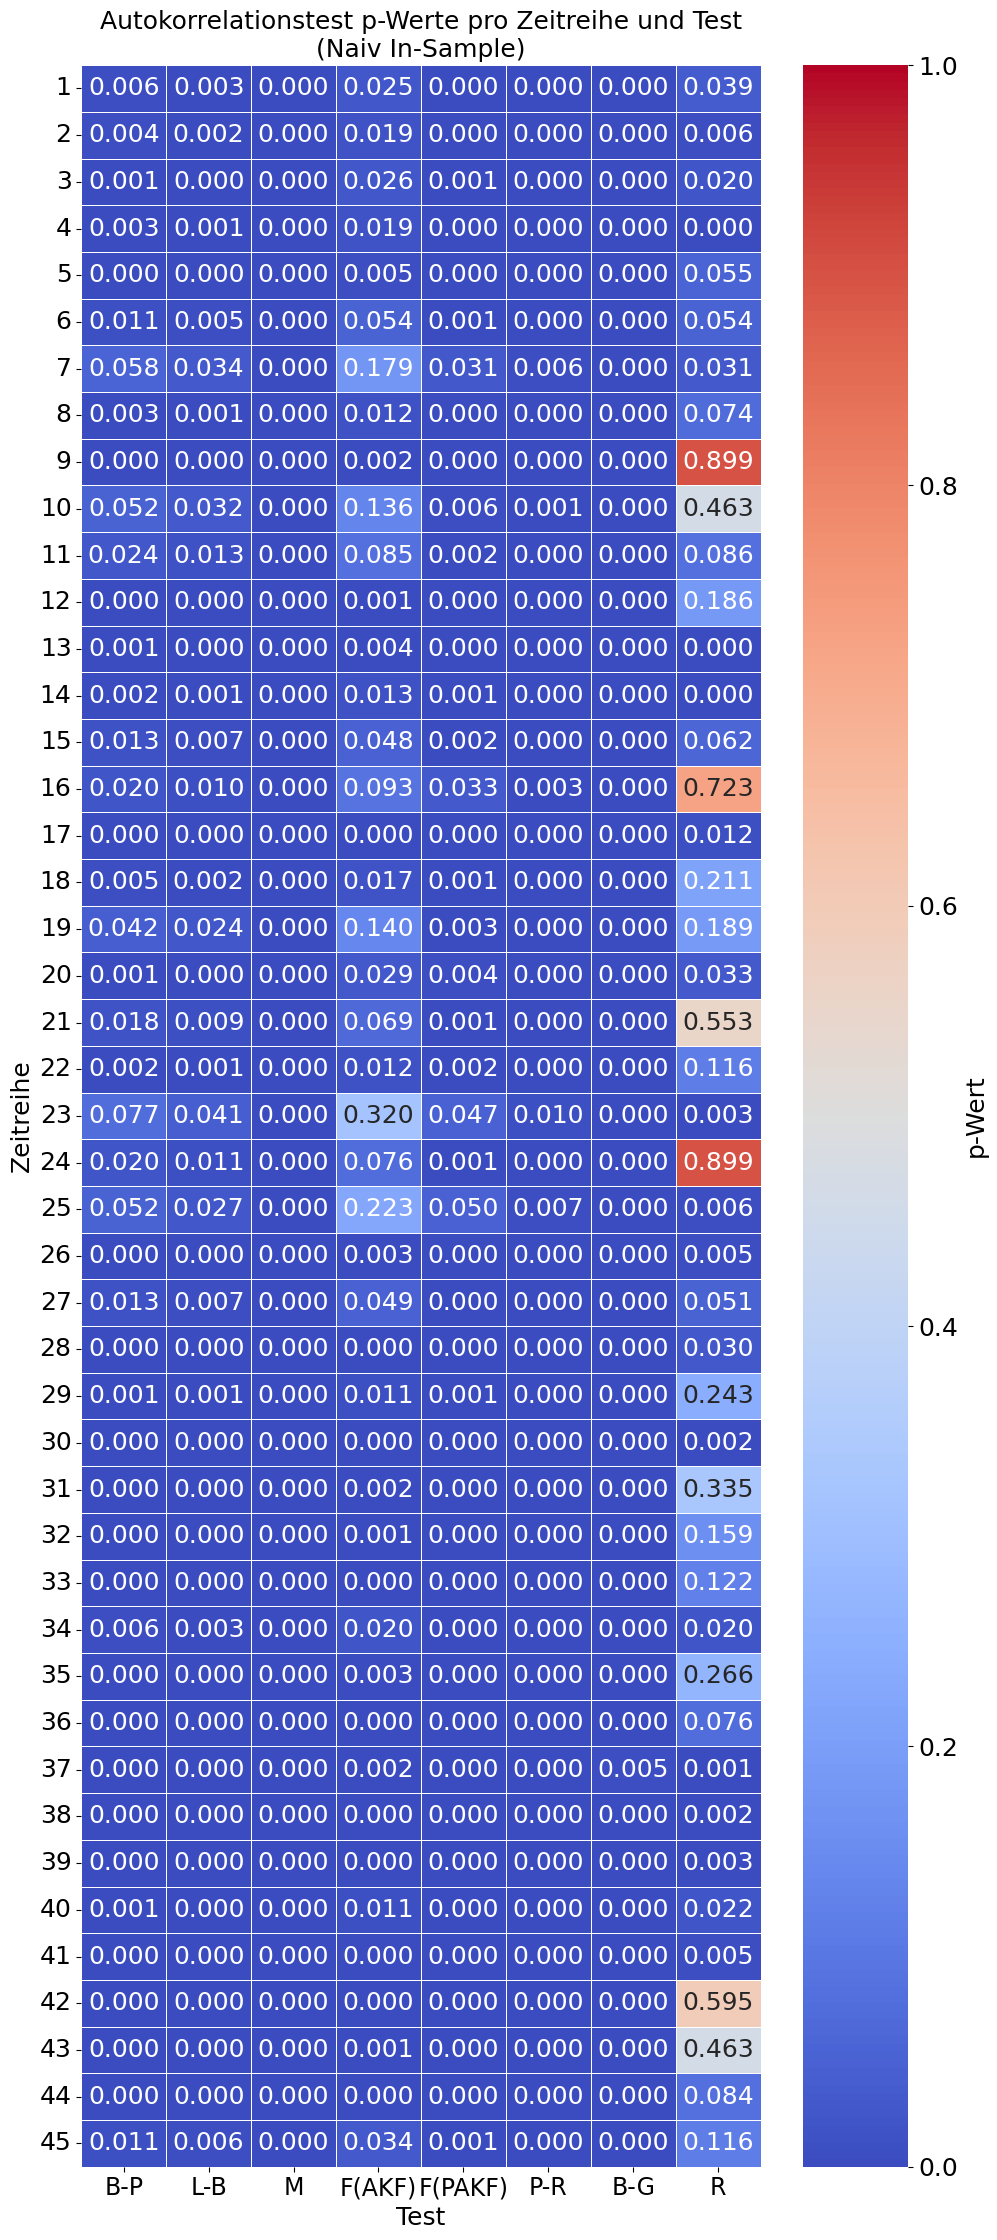

In [7]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []
m_pvalues = []
f_pvalues = []
f2_pvalues = []
pr_pvalues = []
pr2_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store) #Residuen für den Store

    sales = df[df['store'] == store].copy() #Zeitreihe für den Store
    sales.set_index('date', inplace=True)
    sales = sales['weekly_sales']
    sales = sales.asfreq('W-FRI')

    if resid is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(residuals = resid, store_num = store, model = model_type, sample = "IS", lags = 20, print_results=False)
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(residuals = resid, store_num = store, model = model_type, sample = "IS", lags=20, print_results = False)
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            if model_type == 'SARIMA':
                _, p_value = breusch_godfrey_test(model = sarima_models[store], lags = 20, print_results = False)
            if model_type == 'Additive':
                _, p_value = breusch_godfrey_manuell(sales, lags = 5, print_results = False)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Monti Test
        try:
            _, p_value = monti_test(residuals = resid, store_num=store, model = model_type, m = 20, print_results = False)
            m_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Monti Test für Store {store}: {e}")
            m_pvalues.append(np.nan)
        # Fisher Test (ACF)
        try:
            _, p_value = fisher_test(residuals = resid, store_num = store, model = model_type, version = "acf", m = 20, print_results = False)
            f_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f_pvalues.append(np.nan)
        # Fisher Test (PACF)
        try:
            _, p_value = fisher_test(residuals = resid, store_num = store, model = model_type, version = "pacf", m = 20, print_results = False)
            f2_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f2_pvalues.append(np.nan)
        # Pena Rodriguez Test (Monte Carlo)
        #try:
        #    _, p_value = pena_rodriguez_test_mc(residuals = resid, m = 20, print_results= False)
        #    pr2_pvalues.append(p_value)

        except Exception as e:
            print(f"Fehler beim Pena Rodriguez Test für Store {store}: {e}")
            pr2_pvalues.append(np.nan)
        # Pena Rodriguez Test (normal)
        try:
            _, p_value = pena_rodriguez_test_original(residuals = resid, store_num = store, model = model_type, m = 20, print_results= False)
            pr_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Pena Rodriguez Test für Store {store}: {e}")
            pr_pvalues.append(np.nan)

        # Runs Test
        try:
            _, p_value = run_test(residuals = resid, print_results = False)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)
        m_pvalues.append(np.nan)
        f_pvalues.append(np.nan)
        f2_pvalues.append(np.nan)
        pr2_pvalues.append(np.nan)



pvalues = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr_pvalues, bg_pvalues, rt_pvalues])



# Boxplot aller p-Werte
plt.figure(figsize=(12, 6))
meanprops = dict(marker='^',            # Dreieck
                 markerfacecolor="#00E034", # Füllfarbe
                 markeredgecolor='#00E034') # Randfarbe
plt.boxplot(pvalues, patch_artist=True, showmeans=True, meanprops=meanprops, medianprops=dict(color="#FF9D26"))
plt.title('Autokorrelationstests p-Werte aller Zeitreihen (Naiv In-Sample)')
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (AKF)", "Fisher (PAKF)", "Peña-Rodríguez", "Breusch-Godfrey", "Runs"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.ylim(-0.05, 1.05)
plt.show()

print('BOX-PIERCE Mittelwert:', pd.Series(bp_pvalues).mean(), 
      'Median:', pd.Series(bp_pvalues).median(),
      'Standardabweichung:', pd.Series(bp_pvalues).std(),
      'Annahme (%):', (pd.Series(bp_pvalues) >= 0.05).mean() * 100)
print('LJUNG-BOX Mittelwert:', pd.Series(lb_pvalues).mean(),
      'Median:', pd.Series(lb_pvalues).median(),
      'Standardabweichung:', pd.Series(lb_pvalues).std(),
      'Annahme (%):', (pd.Series(lb_pvalues) >= 0.05).mean() * 100)
print('MONTI Mittelwert:', pd.Series(m_pvalues).mean(),
      'Median:', pd.Series(m_pvalues).median(),
      'Standardabweichung:', pd.Series(m_pvalues).std(),
      'Annahme (%):', (pd.Series(m_pvalues) >= 0.05).mean() * 100)
print('FISHER (AKF) Mittelwert:', pd.Series(f_pvalues).mean(),
      'Median:', pd.Series(f_pvalues).median(),
      'Standardabweichung:', pd.Series(f_pvalues).std(),
      'Annahme (%):', (pd.Series(f_pvalues) >= 0.05).mean() * 100)
print('FISHER (PAKF) Mittelwert:', pd.Series(f2_pvalues).mean(),
      'Median:', pd.Series(f2_pvalues).median(),
      'Standardabweichung:', pd.Series(f2_pvalues).std(),
      'Annahme (%):', (pd.Series(f2_pvalues) >= 0.05).mean() * 100)
print('PEÑA-RODRIGUEZ Mittelwert:', pd.Series(pr_pvalues).mean(),
      'Median:', pd.Series(pr_pvalues).median(),
      'Standardabweichung:', pd.Series(pr_pvalues).std(),
      'Annahme (%):', (pd.Series(pr_pvalues) >= 0.05).mean() * 100)
print('BREUSCH-GODFREY Mittelwert:', pd.Series(bg_pvalues).mean(),
      'Median:', pd.Series(bg_pvalues).median(),
      'Standardabweichung:', pd.Series(bg_pvalues).std(),
      'Annahme (%):', (pd.Series(bg_pvalues) >= 0.05).mean() * 100)
print('RUNS Mittelwert:', pd.Series(rt_pvalues).mean(),
      'Median:', pd.Series(rt_pvalues).median(),
      'Standardabweichung:', pd.Series(rt_pvalues).std(),
      'Annahme (%):', (pd.Series(rt_pvalues) >= 0.05).mean() * 100)



# Heatmap der p-Werte
store_names = [f"{i+1}" for i in range(pvalues.shape[0])]
columns = ["B-P", "L-B", "M", "F(AKF)",
           "F(PAKF)", "P-R", "B-G", "R"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)

plt.figure(figsize=(10, len(store_names) * 0.5))
ax = sns.heatmap(
    df_pvalues,
    annot=True,
    fmt=".3f",
    annot_kws={"size": 18},
    cmap="coolwarm",
    cbar_kws={'label': 'p-Wert'},
    vmin=0,
    vmax=1,
    linewidths=0.7,         # Breite der Linien zwischen den Zellen
    linecolor='white'     # Farbe der Linien
)

# Colorbar
cbar = ax.collections[0].colorbar
# Tick-Labels der Colorbar
cbar.ax.tick_params(labelsize=18)
# Label der Colorbar (p-Wert)
cbar.set_label('p-Wert', fontsize=18)
# Achsen-Tick-Labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=17)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18)
# Titel und Achsenbeschriftungen
plt.title(
    'Autokorrelationstest p-Werte pro Zeitreihe und Test\n'
    '(Naiv In-Sample)',
    fontsize=18
)
plt.xlabel("Test", fontsize=18)
plt.ylabel("Zeitreihe", fontsize=18)

plt.tight_layout()
plt.show()




Durbin Watson

[2.7146724074428352, 2.7247710301042174, 2.584930696637733, 2.7451454825392623, 2.799699075351027, 2.6215101791387987, 2.613693982582782, 2.713121400032987, 2.7225498261471484, 2.581300006195319, 2.552540386354194, 2.7138638963134607, 2.7370250050930602, 2.7677326855103495, 2.6485131718949684, 2.6776694577180664, 3.180873543872119, 2.8333389881452677, 2.7107960039892096, 2.7391683942246456, 2.5378372780372747, 2.7231138506635464, 2.577938096001692, 2.7205456860697628, 2.5587303356641904, 2.877016351872089, 2.7978766547798726, 2.9215592568771926, 2.6341782462843186, 2.961127600434091, 2.7308717348098765, 2.777339172324431, 2.333455675700808, 2.7671840821931064, 2.696113299456546, 2.6197325274422227, 3.076104339836067, 2.9837495690770344, 2.784333590343012, 2.8717564742787327, 2.90804414624634, 2.3017403598611232, 2.612068030931472, 3.160927760762069, 2.7027239445084272]


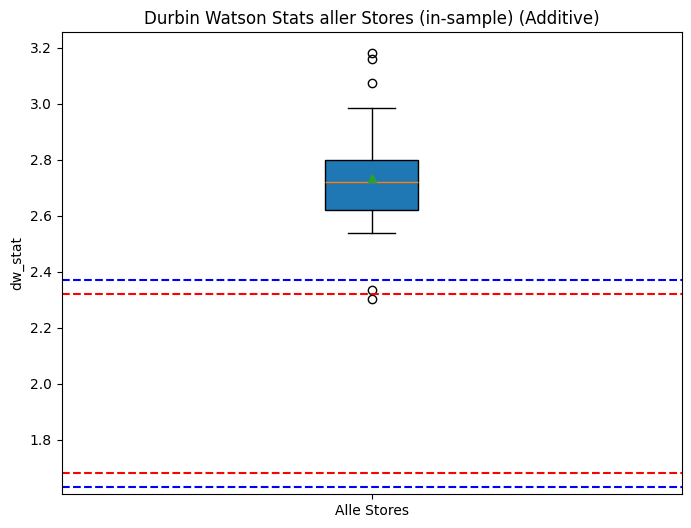

Mittelwert: 2.733755192972061
Median: 2.7225498261471484


In [8]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        try:
            dw_stat = durbin_watson_test(resid, False)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

print(dw_stats)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True, showmeans=True)
plt.title('Durbin Watson Stats aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.axhline(1.68, color='red', linestyle='--', label='dU')
plt.axhline(4-1.68, color='red', linestyle='--', label='4-dU')
plt.axhline(1.63, color='blue', linestyle='--', label='dL')
plt.axhline(4-1.63, color='blue', linestyle='--', label='4-dL')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwert:", np.mean(dw_stats))
print("Median:", np.median(dw_stats))


ACF Plots

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 3, 4, 3, 3, 15, 3, 3, 9, 2, 7, 4, 4, 4, 14, 9, 6, 3]
45


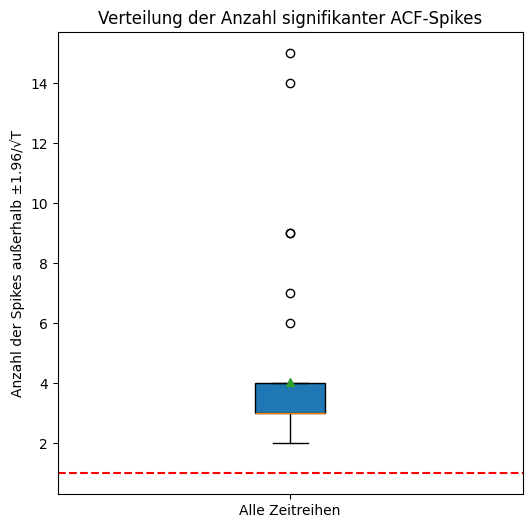

In [9]:

spikes = {}
for store in range(1, 46):
    resid = residuals_dict.get(store)
    spikes[store] = count_spikes(resid, lags = 20)
    #print(spikes[store])


values = list(spikes.values())
print(values)
print(len(values))

plt.figure(figsize=(6, 6))
plt.boxplot(values, patch_artist=True, showmeans=True)
plt.title("Verteilung der Anzahl signifikanter ACF-Spikes")
plt.ylabel("Anzahl der Spikes außerhalb ±1.96/√T")
plt.xticks([1], ["Alle Zeitreihen"])
plt.axhline(20*0.05, color='red', linestyle='--')
plt.show()



Mittelwert Tests

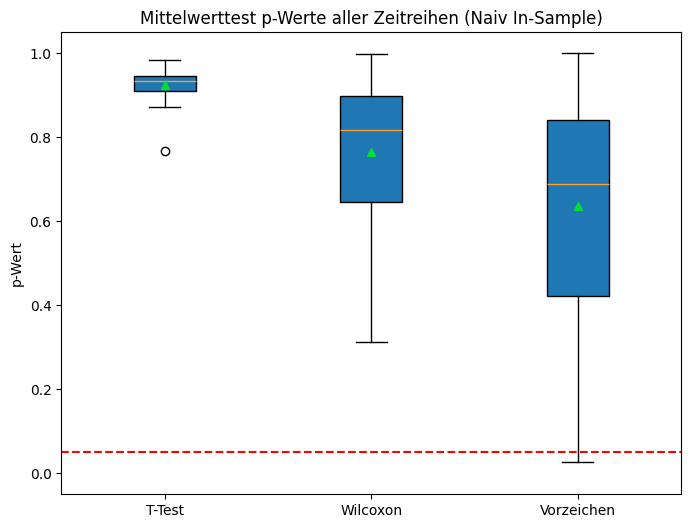

T-TEST Mittelwert: 0.9237449470101899 Median: 0.9338551144311086 Standardabweichung: 0.0365992514663796 Annahme (%): 100.0
WILCOXON Mittelwert: 0.7638937723726653 Median: 0.817259791460541 Standardabweichung: 0.17708224037111653 Annahme (%): 100.0
VORZEICHEN Mittelwert: 0.636286951285187 Median: 0.6878853435796914 Standardabweichung: 0.28560307862263024 Annahme (%): 97.77777777777777


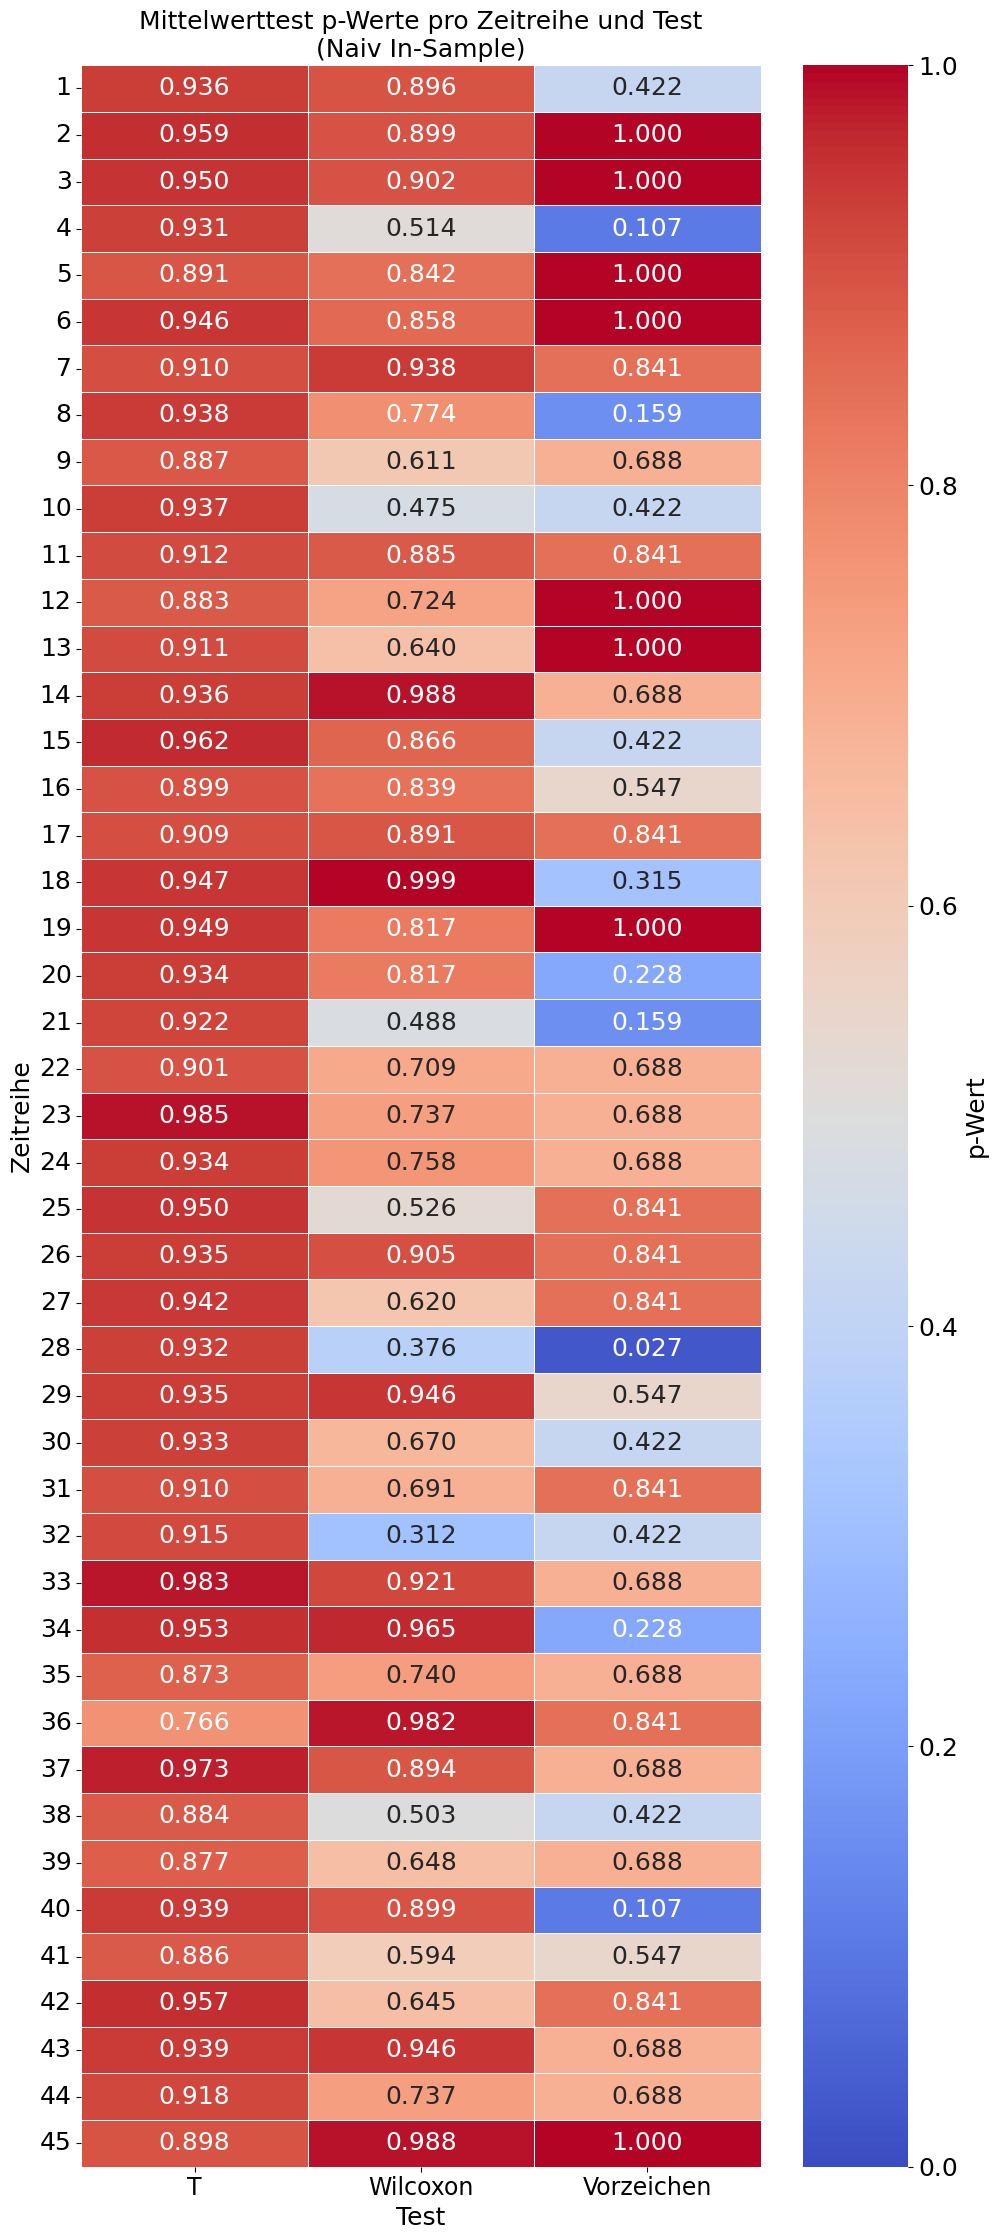

In [10]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []
z_pvalues = []
s_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(resid, False)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(resid, False)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(resid, False)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Sign Test
        try:
            _, s_value = vorzeichen_test(resid, False)
            s_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Sign Test für Store {store}: {e}")
            s_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(resid, False)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
        # Z-Test
        try:
            _, p_value = z_test(resid, False)
            z_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Z-Test für Store {store}: {e}")
            z_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)
        z_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, s_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
meanprops = dict(marker='^',            # Dreieck
                 markerfacecolor="#00E034", # Füllfarbe
                 markeredgecolor='#00E034') # Randfarbe
plt.boxplot(pvalues, patch_artist=True, showmeans=True, meanprops=meanprops, medianprops=dict(color="#FF9D26"))
plt.title('Mittelwerttest p-Werte aller Zeitreihen (Naiv In-Sample)')
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3], ["T-Test", "Wilcoxon", "Vorzeichen"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.ylim(-0.05, 1.05)
plt.show()

# Mittelwerte und Median der p-Werte

print('T-TEST Mittelwert:', pd.Series(t_pvalues).mean(), 
      'Median:', pd.Series(t_pvalues).median(),
      'Standardabweichung:', pd.Series(t_pvalues).std(),
      'Annahme (%):', (pd.Series(t_pvalues) >= 0.05).mean() * 100)
print('WILCOXON Mittelwert:', pd.Series(w_pvalues).mean(),
      'Median:', pd.Series(w_pvalues).median(),
      'Standardabweichung:', pd.Series(w_pvalues).std(),
      'Annahme (%):', (pd.Series(w_pvalues) >= 0.05).mean() * 100)
print('VORZEICHEN Mittelwert:', pd.Series(s_pvalues).mean(),
      'Median:', pd.Series(s_pvalues).median(),
      'Standardabweichung:', pd.Series(s_pvalues).std(),
      'Annahme (%):', (pd.Series(s_pvalues) >= 0.05).mean() * 100)





# Heatmap der p-Werte
store_names = [f"{i+1}" for i in range(pvalues.shape[0])]
columns = ["T", "Wilcoxon", "Vorzeichen"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)

plt.figure(figsize=(10, len(store_names) * 0.5))
ax = sns.heatmap(
    df_pvalues,
    annot=True,
    fmt=".3f",
    annot_kws={"size": 18},
    cmap="coolwarm",
    cbar_kws={'label': 'p-Wert'},
    vmin=0,
    vmax=1,
    linewidths=0.7,         # Breite der Linien zwischen den Zellen
    linecolor='white'     # Farbe der Linien
)

# Colorbar
cbar = ax.collections[0].colorbar
# Tick-Labels der Colorbar
cbar.ax.tick_params(labelsize=18)
# Label der Colorbar (p-Wert)
cbar.set_label('p-Wert', fontsize=18)
# Achsen-Tick-Labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=17)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18)
# Titel und Achsenbeschriftungen
plt.title(
    'Mittelwerttest p-Werte pro Zeitreihe und Test\n'
    '(Naiv In-Sample)',
    fontsize=18
)
plt.xlabel("Test", fontsize=18)
plt.ylabel("Zeitreihe", fontsize=18)

plt.tight_layout()
plt.show()




SMAPE

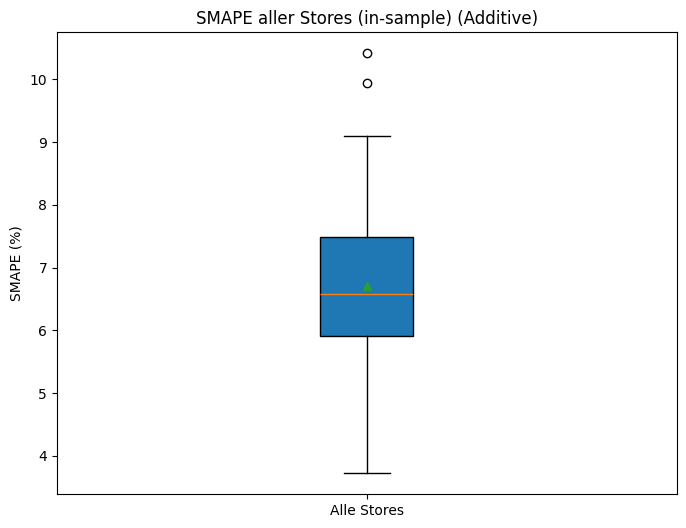

Mittelwert: 6.706795282592895 %
Median: 6.5767034589613775 %
[5.9530026965794205, 5.902598000158378, 6.634969384029605, 5.653606797355883, 6.835319801056889, 6.290592231012177, 7.293410797888406, 6.027232348716425, 5.971220969291638, 5.529742918031621, 6.075476099346715, 6.324373528850595, 6.00889744942883, 9.098313019616052, 8.139124673088036, 6.703957945045948, 7.698820513030115, 9.00344638216611, 6.75343684838903, 7.232735359792149, 6.946826563677347, 7.65531919899279, 8.84546397983731, 7.486637060972049, 6.514385940175002, 7.020733043698399, 8.76148097527435, 9.949240511795617, 8.6903508114113, 3.7310702821114927, 5.110637275121996, 5.195027548440403, 6.721298060777749, 5.420999664687818, 10.41650270626857, 4.882433288926234, 3.721643296745104, 5.436395783943512, 6.215134977504002, 7.439729590247428, 6.4589893607240505, 6.5767034589613775, 4.768101082130463, 4.717821255795954, 7.992584235585911]


In [11]:
smape_stats = []

for store in range(1, 46):
    y_train = y_train_dict.get(store) # wahre Werte
    fitted = fitted_values_dict.get(store) # geschätzte Werte

    # SMAPE berechnen

    denom = (np.abs(y_train) + np.abs(fitted))
    # Vermeide Division durch 0
    mask = denom != 0
    smape = 100 * np.mean(2 * np.abs(fitted[mask] - y_train[mask]) / denom[mask])
    smape_stats.append(smape)

# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(smape_stats, patch_artist=True, showmeans=True)
plt.title(f'SMAPE aller Stores (in-sample) ({model_type})')
plt.ylabel("SMAPE (%)")
plt.xticks([1], ["Alle Stores"])
plt.show()

# Mittelwerte und Median der SMAPE Werte
print("Mittelwert:",np.mean(smape_stats), "%")
print("Median:",np.median(smape_stats), "%")
print(smape_stats)


SMAPE vs. Autokorrelation p-Werte

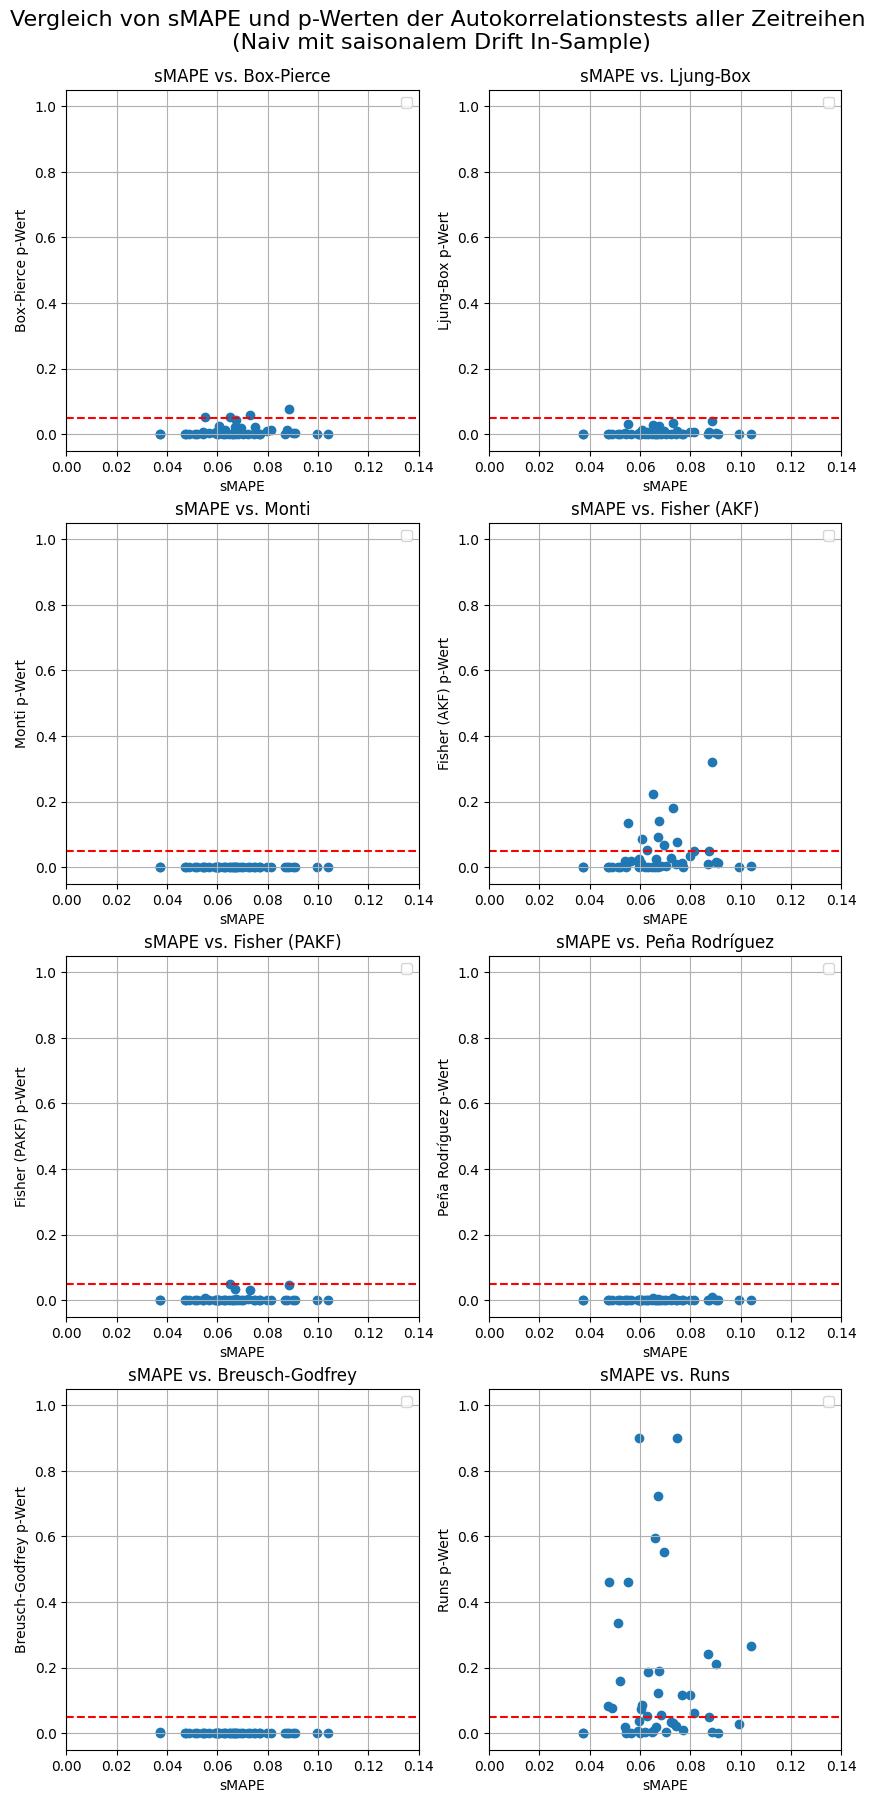

[[0.005535178510335035, 0.003929371173924317, 0.0014406950741770515, 0.0025621834416167588, 0.0004276065054935761, 0.011297953995299646, 0.058254657253226476, 0.0028621260201089015, 0.00018144992264308864, 0.05162860248418402, 0.0235301374710907, 3.42713133316959e-05, 0.000606906445908568, 0.0021605469607185344, 0.013314818703860802, 0.02039201423882874, 6.159040252030128e-08, 0.004808977897928022, 0.04183020041396463, 0.0008273686517283171, 0.017728604023320552, 0.001515432034542923, 0.07682298847289651, 0.020480037518842607, 0.051853696056280506, 0.0003198722724660114, 0.01294221448913341, 6.965690489750744e-06, 0.0013660926288550411, 4.029188669771215e-07, 0.000187227457974737, 9.116460522538702e-05, 2.927483096163484e-31, 0.006072668309218162, 0.00031133349483596686, 1.667800213002551e-10, 0.000194167184231451, 1.118398867244982e-12, 4.721038077036122e-05, 0.0006147565242110648, 1.0587042074739462e-05, 4.186725210799006e-49, 9.310354367809293e-08, 9.529315153069101e-07, 0.010800173

In [12]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))

smape_dec = np.asarray(smape_stats) / 100
p_values_list = [bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr_pvalues, bg_pvalues, rt_pvalues]
test_names = ["Box-Pierce", "Ljung-Box", "Monti", "Fisher (AKF)", "Fisher (PAKF)", "Peña Rodríguez", "Breusch-Godfrey", "Runs"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_dec, p_values_list[i])
    ax.set_xlabel('sMAPE')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'sMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--')
    ax.legend()
    ax.set_xlim(0, 0.14)
    ax.set_ylim(-0.05, 1.05)


fig.suptitle('Vergleich von sMAPE und p-Werten der Autokorrelationstests aller Zeitreihen \n'
    '(Naiv mit saisonalem Drift In-Sample)', fontsize=16)
#plt.tight_layout()
fig.subplots_adjust(top=0.94)
plt.show()


print(p_values_list)

SMAPE vs Mittelwert p-Werte

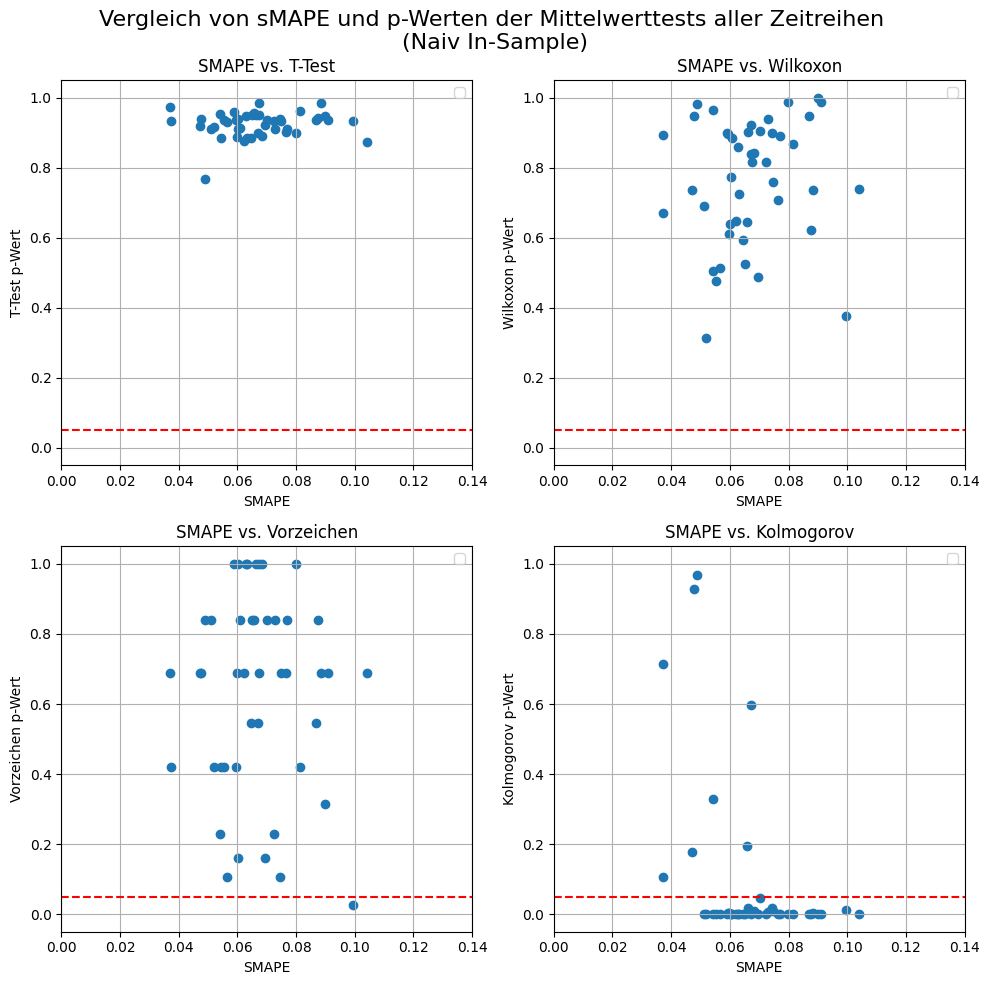

[[0.9358217604482433, 0.9590898239734185, 0.9496078531107015, 0.9314109030407602, 0.8913369878467847, 0.9461557216312622, 0.9100558912701096, 0.9378478836748307, 0.8873418638290629, 0.936738897165985, 0.9124337677358736, 0.8833953055490604, 0.9110081293089836, 0.9358350413162331, 0.9615725491673441, 0.8990805955423007, 0.9090190278948105, 0.947440383591266, 0.9490400865815944, 0.9339600113182118, 0.9224554681084257, 0.9009507317658432, 0.9846875968980466, 0.9338551144311086, 0.9504829338037548, 0.9348726372874389, 0.9415463615811978, 0.931761128339823, 0.9351493452192212, 0.9330504797610154, 0.9098748945724182, 0.914759598454737, 0.9833385196740714, 0.9534440126074263, 0.8732787188401243, 0.7664155029603671, 0.9732896343092214, 0.8840322020477283, 0.8765190962976033, 0.9385645968528029, 0.8858172713507116, 0.9571423194739177, 0.9389698865299096, 0.9184178880444243, 0.8976541922503736], [0.8963322882795601, 0.899081903594438, 0.9018327198941375, 0.5144784237589191, 0.8416416819604404, 0

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

smape_dec = np.asarray(smape_stats) / 100
p_values_list = [t_pvalues, w_pvalues, s_pvalues, k_pvalues]
test_names = ["T-Test", "Wilkoxon", "Vorzeichen", "Kolmogorov"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_dec, p_values_list[i])
    ax.set_xlabel('SMAPE')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--')
    ax.legend()
    ax.set_xlim(0, 0.14)
    ax.set_ylim(-0.05, 1.05)


fig.suptitle('Vergleich von sMAPE und p-Werten der Mittelwerttests aller Zeitreihen \n'
    '(Naiv In-Sample)', fontsize=16)
plt.tight_layout()
fig.subplots_adjust(top=0.91)
plt.show()

print(p_values_list)


p_values_list_new = [t_pvalues, w_pvalues, s_pvalues]
print(p_values_list_new)

Errors

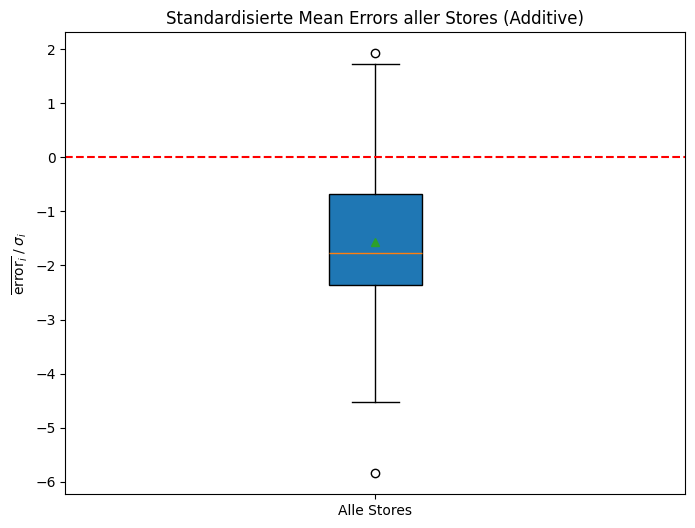

Mittelwert:  -1.5658291756708929
Median:  -1.7656456837397612
[-0.8758790895165552, -0.6746783493102247, 0.25372307888590234, -1.3014768493107385, -1.5310380423420016, -1.095223786553787, -1.678330822812589, -1.7158096700395675, -2.364473977984912, -2.3741391402996626, -1.828141898542447, -4.533057883992181, -2.21085306454595, -2.33638020662617, -1.9725497219954684, -2.854338195920704, -2.133603137509494, -0.6544684591631101, -1.9104778768179742, -1.3260053023671015, -4.019976195984314, -3.4108686966219564, 0.06480941122958418, -1.7656456837397612, -0.9493621945743913, -1.7738199540083326, -2.8497502644399377, -1.785494680695406, -2.355033973017858, 1.4602717009511972, -4.150497739120365, -2.7830551846681506, 1.925235720858695, -0.929475866155763, -5.843434667832883, 0.32995104001596104, 0.9993128120055415, 0.650306275771929, -2.014290596412337, -1.6366769074100498, -3.230563992798296, -0.100443081713777, 1.7329919927625919, 1.0234231386193984, -3.9330229214467636]


In [14]:
error_bias = [] 
for store in sorted(errors_dict.keys(), key=int):
    error = errors_dict[store]
    mean = error.mean()
    std = error.std(ddof=0)        # Populations-Std (ddof=0)
    if std == 0:
        error_bias.append(np.nan)
    else:
        error_bias.append(mean / std) # standardisierter Bias


plt.figure(figsize=(8, 6))
plt.boxplot(error_bias, patch_artist=True, showmeans=True)
plt.title('Standardisierte Mean Errors aller Stores ({})'.format(model_type))
plt.ylabel(r'$\overline{\mathrm{error}_i}\; / \;\sigma_i$')
plt.xticks([1], ['Alle Stores'])
plt.axhline(0, color = 'red', ls='--')
plt.show()

print("Mittelwert: ", np.mean(error_bias))
print("Median: ", np.median(error_bias))

print(error_bias)


Korrelations Test

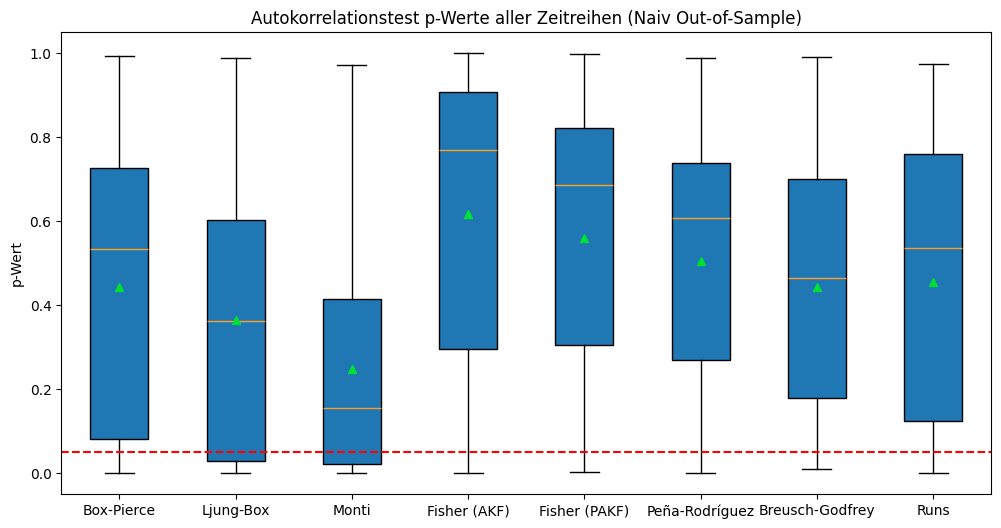

BOX-PIERCE Mittelwert: 0.4418781213324767 Median: 0.5329893382333459 Standardabweichung: 0.3248744827689554 Annahme (%): 75.55555555555556
LJUNG-BOX Mittelwert: 0.3627362294496338 Median: 0.3618348241224936 Standardabweichung: 0.3031893694320398 Annahme (%): 73.33333333333333
MONTI Mittelwert: 0.24706818563076594 Median: 0.15430604466115616 Standardabweichung: 0.2576080968709492 Annahme (%): 66.66666666666666
FISHER (AKF) Mittelwert: 0.6159100025146436 Median: 0.7675169620657787 Standardabweichung: 0.3562167624381068 Annahme (%): 84.44444444444444
FISHER (PAKF) Mittelwert: 0.5592746955893353 Median: 0.6847258668185093 Standardabweichung: 0.32562804337374457 Annahme (%): 82.22222222222221
PEÑA-RODRIGUEZ Mittelwert: 0.5044638487434553 Median: 0.6057573044637403 Standardabweichung: 0.3074624496285323 Annahme (%): 82.22222222222221
BREUSCH-GODFREY Mittelwert: 0.4421458873306308 Median: 0.46327781252466316 Standardabweichung: 0.2939197030314486 Annahme (%): 86.66666666666667
RUNS Mittelwert

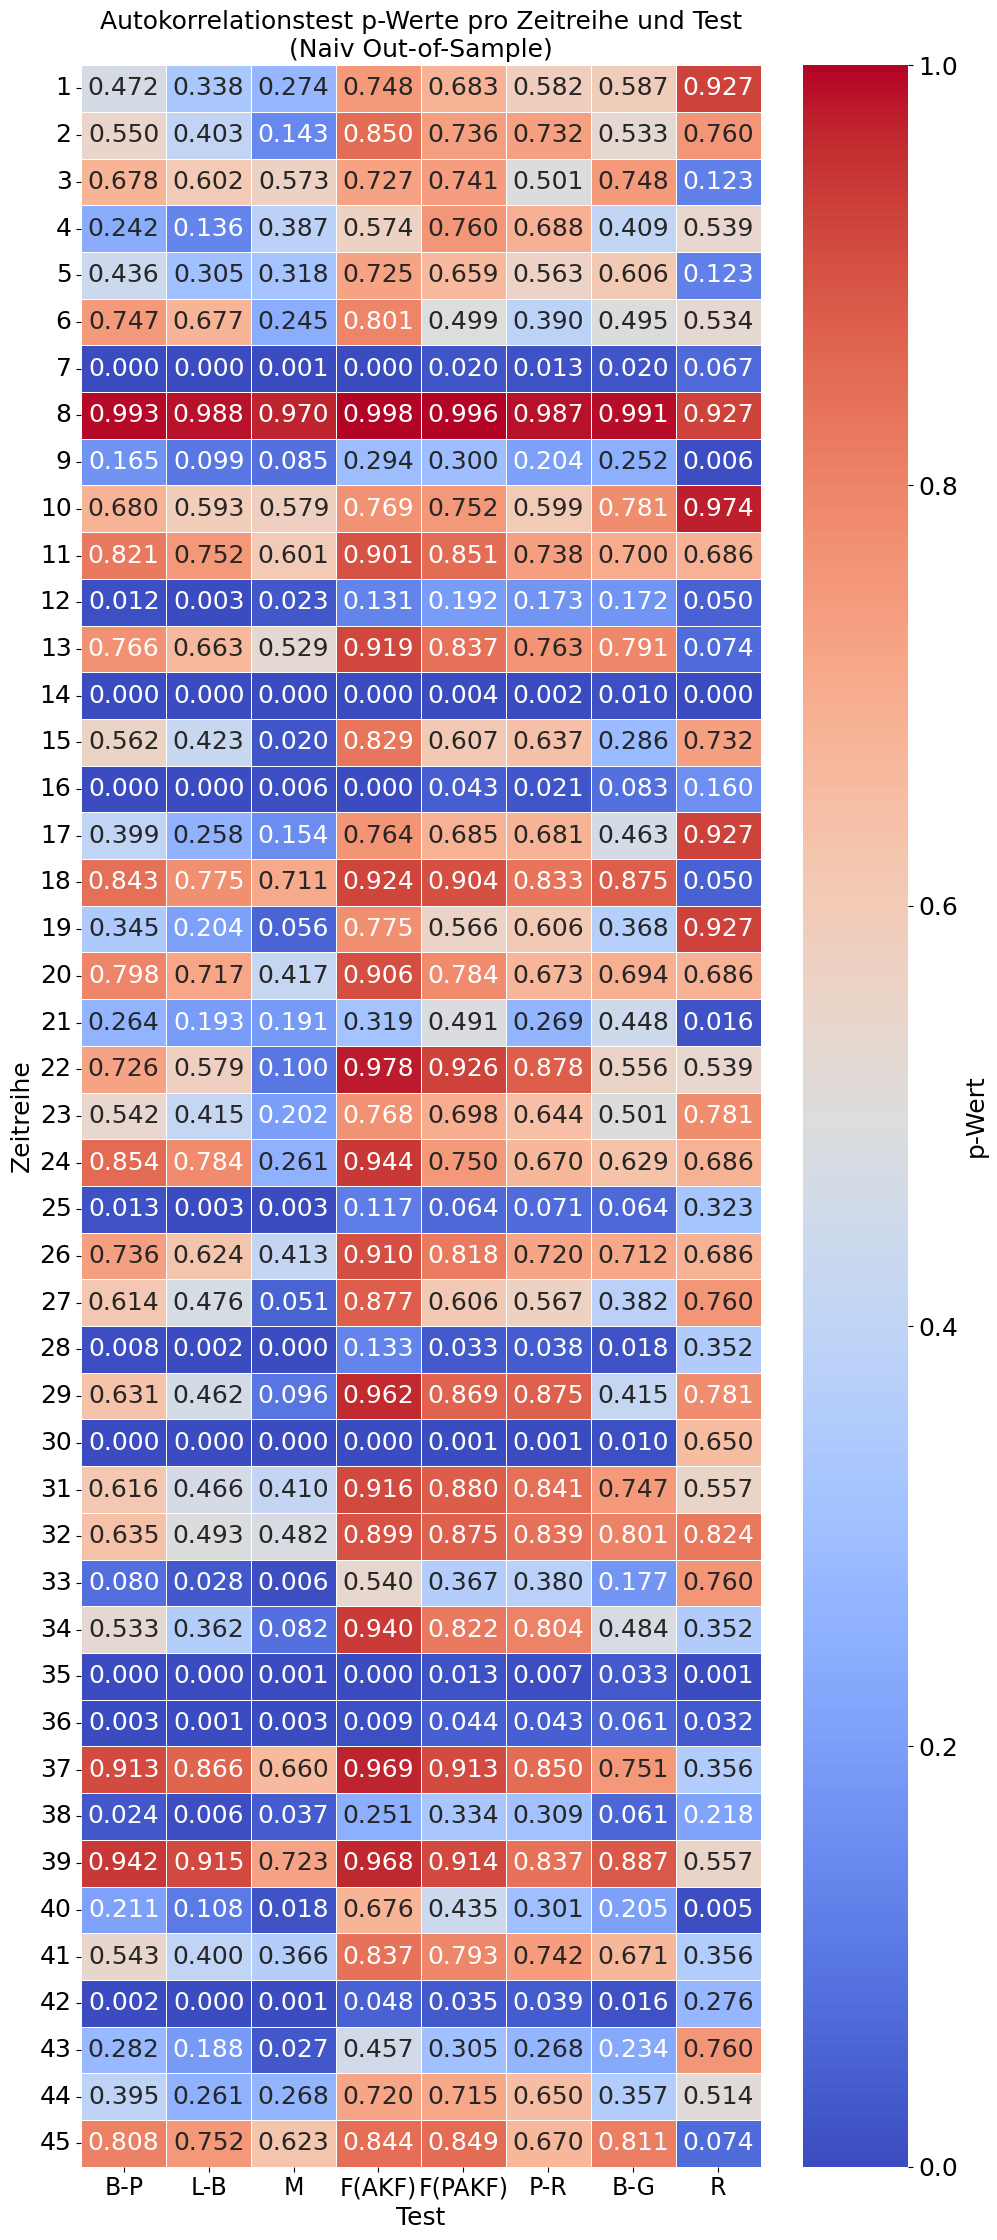

In [15]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []
m_pvalues = []
f_pvalues = []
f2_pvalues = []
pr2_pvalues = []
pr_pvalues = []


# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = errors_dict.get(store) #Residuen für den Store

    sales = df[df['store'] == store].copy() #Zeitreihe für den Store
    sales.set_index('date', inplace=True)
    sales = sales['weekly_sales']
    sales = sales.asfreq('W-FRI')

    if errors is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(residuals = errors, store_num = store, model = model_type, sample = "OOS", lags = 9, print_results=False)
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(residuals = errors, store_num = store, model = model_type, sample = "OOS", lags = 9, print_results=False)
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            _, p_value = breusch_godfrey_manuell(errors=errors, lags = 9, print_results = False)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Monti Test
        try:
            _, p_value = monti_test(residuals = errors, store_num = store, model = model_type, m = 9, print_results = False)
            m_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Monti Test für Store {store}: {e}")
            m_pvalues.append(np.nan)
        # Fisher Test (ACF)
        try:
            _, p_value = fisher_test(residuals = errors, store_num = store, model = model_type, version = "acf", m = 9, print_results = False)
            f_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f_pvalues.append(np.nan)
        # Fisher Test (PACF)
        try:
            sarima_params  = optimal_orders_5.get(str(store))
            order = tuple(sarima_params["order"])
            _, p_value = fisher_test(residuals = errors, store_num = store, model = model_type, version = "pacf", m = 9, print_results = False)
            f2_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f2_pvalues.append(np.nan)
        # Pena Rodriguez Test (Monte Carlo)
        #try:
        #    _, p_value = pena_rodriguez_test_mc(residuals = errors, m = 9, print_results= False)
        #    pr2_pvalues.append(p_value)

        except Exception as e:
            print(f"Fehler beim Pena Rodriguez Test für Store {store}: {e}")
            pr2_pvalues.append(np.nan)
        # Pena Rodriguez Test (normal)
        try:
            _, p_value = pena_rodriguez_test_original(residuals = errors, store_num = store, model = model_type, m = 9, print_results= False)
            pr_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Pena Rodriguez Test für Store {store}: {e}")
            pr_pvalues.append(np.nan)
        # Runs Test
        try:
            _, p_value = run_test(residuals = errors, print_results=False)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)
        m_pvalues.append(np.nan)
        f_pvalues.append(np.nan)
        f2_pvalues.append(np.nan)
        pr_pvalues.append(np.nan)


pvalues = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr_pvalues, bg_pvalues, rt_pvalues])


# Boxplot aller p-Werte
plt.figure(figsize=(12, 6))
meanprops = dict(marker='^',            # Dreieck
                 markerfacecolor="#00E034", # Füllfarbe
                 markeredgecolor='#00E034') # Randfarbe
plt.boxplot(pvalues, patch_artist=True, showmeans=True, meanprops=meanprops, medianprops=dict(color="#FF9D26"))
plt.title('Autokorrelationstest p-Werte aller Zeitreihen (Naiv Out-of-Sample)')
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (AKF)", "Fisher (PAKF)", "Peña-Rodríguez", "Breusch-Godfrey", "Runs"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.ylim(-0.05, 1.05)
plt.show()

print('BOX-PIERCE Mittelwert:', pd.Series(bp_pvalues).mean(), 
      'Median:', pd.Series(bp_pvalues).median(),
      'Standardabweichung:', pd.Series(bp_pvalues).std(),
      'Annahme (%):', (pd.Series(bp_pvalues) >= 0.05).mean() * 100)
print('LJUNG-BOX Mittelwert:', pd.Series(lb_pvalues).mean(),
      'Median:', pd.Series(lb_pvalues).median(),
      'Standardabweichung:', pd.Series(lb_pvalues).std(),
      'Annahme (%):', (pd.Series(lb_pvalues) >= 0.05).mean() * 100)
print('MONTI Mittelwert:', pd.Series(m_pvalues).mean(),
      'Median:', pd.Series(m_pvalues).median(),
      'Standardabweichung:', pd.Series(m_pvalues).std(),
      'Annahme (%):', (pd.Series(m_pvalues) >= 0.05).mean() * 100)
print('FISHER (AKF) Mittelwert:', pd.Series(f_pvalues).mean(),
      'Median:', pd.Series(f_pvalues).median(),
      'Standardabweichung:', pd.Series(f_pvalues).std(),
      'Annahme (%):', (pd.Series(f_pvalues) >= 0.05).mean() * 100)
print('FISHER (PAKF) Mittelwert:', pd.Series(f2_pvalues).mean(),
      'Median:', pd.Series(f2_pvalues).median(),
      'Standardabweichung:', pd.Series(f2_pvalues).std(),
      'Annahme (%):', (pd.Series(f2_pvalues) >= 0.05).mean() * 100)
print('PEÑA-RODRIGUEZ Mittelwert:', pd.Series(pr_pvalues).mean(),
      'Median:', pd.Series(pr_pvalues).median(),
      'Standardabweichung:', pd.Series(pr_pvalues).std(),
      'Annahme (%):', (pd.Series(pr_pvalues) >= 0.05).mean() * 100)
print('BREUSCH-GODFREY Mittelwert:', pd.Series(bg_pvalues).mean(),
      'Median:', pd.Series(bg_pvalues).median(),
      'Standardabweichung:', pd.Series(bg_pvalues).std(),
      'Annahme (%):', (pd.Series(bg_pvalues) >= 0.05).mean() * 100)
print('RUNS Mittelwert:', pd.Series(rt_pvalues).mean(),
      'Median:', pd.Series(rt_pvalues).median(),
      'Standardabweichung:', pd.Series(rt_pvalues).std(),
      'Annahme (%):', (pd.Series(rt_pvalues) >= 0.05).mean() * 100)


# Heatmap der p-Werte
store_names = [f"{i+1}" for i in range(pvalues.shape[0])]
columns = ["B-P", "L-B", "M", "F(AKF)",
           "F(PAKF)", "P-R", "B-G", "R"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)

plt.figure(figsize=(10, len(store_names) * 0.5))
ax = sns.heatmap(
    df_pvalues,
    annot=True,
    fmt=".3f",
    annot_kws={"size": 18},
    cmap="coolwarm",
    cbar_kws={'label': 'p-Wert'},
    vmin=0,
    vmax=1,
    linewidths=0.7,         # Breite der Linien zwischen den Zellen
    linecolor='white'     # Farbe der Linien
)

# Colorbar
cbar = ax.collections[0].colorbar

# 1) Tick-Labels der Colorbar
cbar.ax.tick_params(labelsize=18)

# 2) Label der Colorbar (p-Wert)
cbar.set_label('p-Wert', fontsize=18)

# Achsen-Tick-Labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=17)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18)

# Titel und Achsenbeschriftungen
plt.title(
    'Autokorrelationstest p-Werte pro Zeitreihe und Test\n'
    '(Naiv Out-of-Sample)',
    fontsize=18
)
plt.xlabel("Test", fontsize=18)
plt.ylabel("Zeitreihe", fontsize=18)

plt.tight_layout()
plt.show()


Durbin Watson

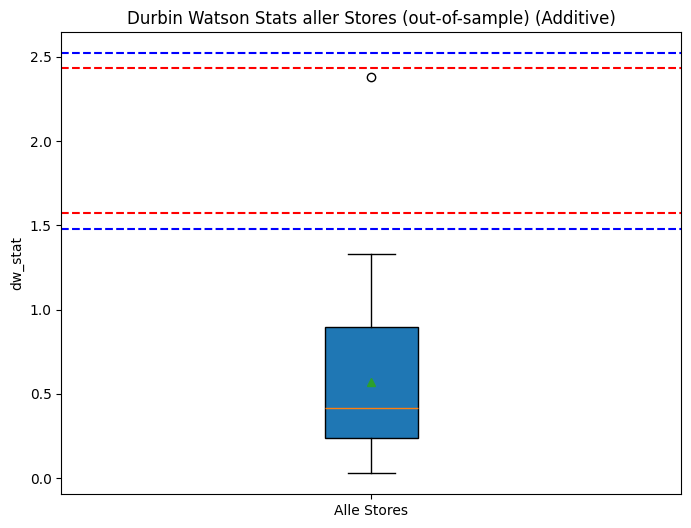

Mittelwert: 0.5710190557778527
Median: 0.41461852500354784
[1.120398703361963, 1.094616077856033, 1.233894904908665, 0.5615323355551355, 0.5121799556691631, 0.9114118602667225, 0.24044442869103833, 0.450425033736081, 0.1914674035007903, 0.25941624164853005, 0.36980043012641906, 0.06461102648796233, 0.31355185891563186, 0.12287332773444133, 0.404333427150241, 0.12225709578004157, 0.36180964551502115, 1.2323578775510067, 0.43461171974648427, 0.6836562423503251, 0.06953330952237287, 0.1788454578890215, 2.381873731859627, 0.5638308836949226, 0.7805455723785737, 0.560395372020619, 0.25595657739818767, 0.6409774355642325, 0.303350429316071, 0.2439295662586233, 0.08527611277794438, 0.20664310988417323, 0.3334770666187922, 1.0734904718008234, 0.02911879766262737, 1.0711150189631367, 0.8947143943052722, 1.1619574559668477, 0.36190202808585237, 0.6907009078327133, 0.1671214859888281, 1.327220347796123, 0.41461852500354784, 1.127904996357245, 0.0857088585055015]


In [16]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    error = errors_dict.get(store) #Errors für den Store
    if error is not None:
        try:
            dw_stat = durbin_watson_test(error, False)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True, showmeans=True)
plt.title('Durbin Watson Stats aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.axhline(1.57, color='red', linestyle='--', label='dU')
plt.axhline(4-1.57, color='red', linestyle='--', label='4-dU')
plt.axhline(1.48, color='blue', linestyle='--', label='dL')
plt.axhline(4-1.48, color='blue', linestyle='--', label='4-dL')
plt.show()

print("Mittelwert:", np.mean(dw_stats))
print("Median:", np.median(dw_stats))

print(dw_stats)


ACF Spikes

[0, 0, 1, 0, 0, 1, 5, 0, 2, 0, 0, 1, 0, 7, 1, 5, 1, 0, 1, 0, 1, 0, 0, 0, 3, 0, 1, 2, 0, 3, 0, 0, 1, 0, 7, 3, 0, 2, 0, 0, 0, 4, 1, 0, 0]
45


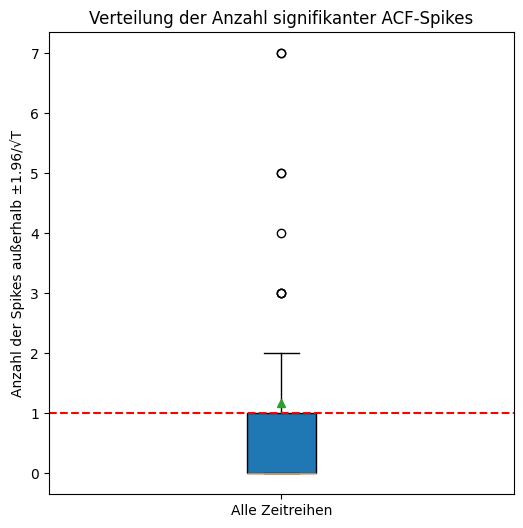

In [17]:
spikes = {}
for store in range(1, 46):
    resid = errors_dict.get(store)
    spikes[store] = count_spikes(resid, lags = 8)
    #print(spikes[store])


values = list(spikes.values())
print(values)
print(len(values))

plt.figure(figsize=(6, 6))
plt.boxplot(values, patch_artist=True, showmeans=True)
plt.title("Verteilung der Anzahl signifikanter ACF-Spikes")
plt.ylabel("Anzahl der Spikes außerhalb ±1.96/√T")
plt.xticks([1], ["Alle Zeitreihen"])
plt.axhline(20*0.05, color='red', linestyle='--')
plt.show()

Mittelwert Tests

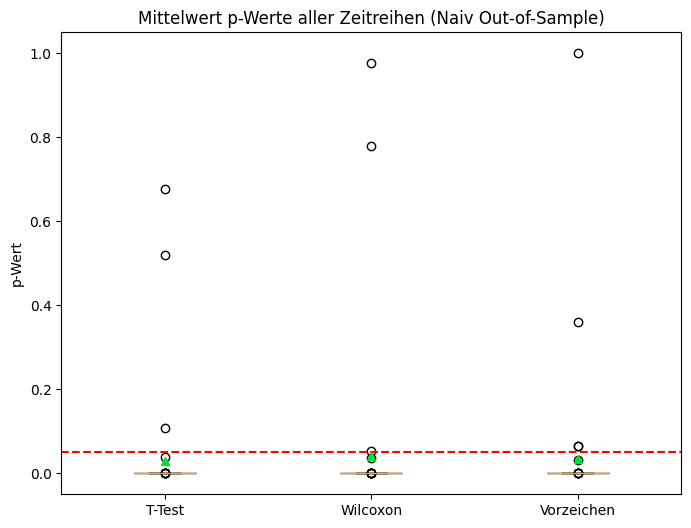

T-TEST Mittelwert: 0.029811199819544124 Median: 1.4907218916849957e-14 Standardabweichung: 0.1261165322226621 Annahme (%): 6.666666666666667
WILCOXON Mittelwert: 0.040966710243416554 Median: 5.6843418860808015e-12 Standardabweichung: 0.1838926637087971 Annahme (%): 6.666666666666667
VORZEICHEN Mittelwert: 0.033866473111008114 Median: 1.000444171950221e-11 Standardabweichung: 0.15724655013356922 Annahme (%): 8.88888888888889


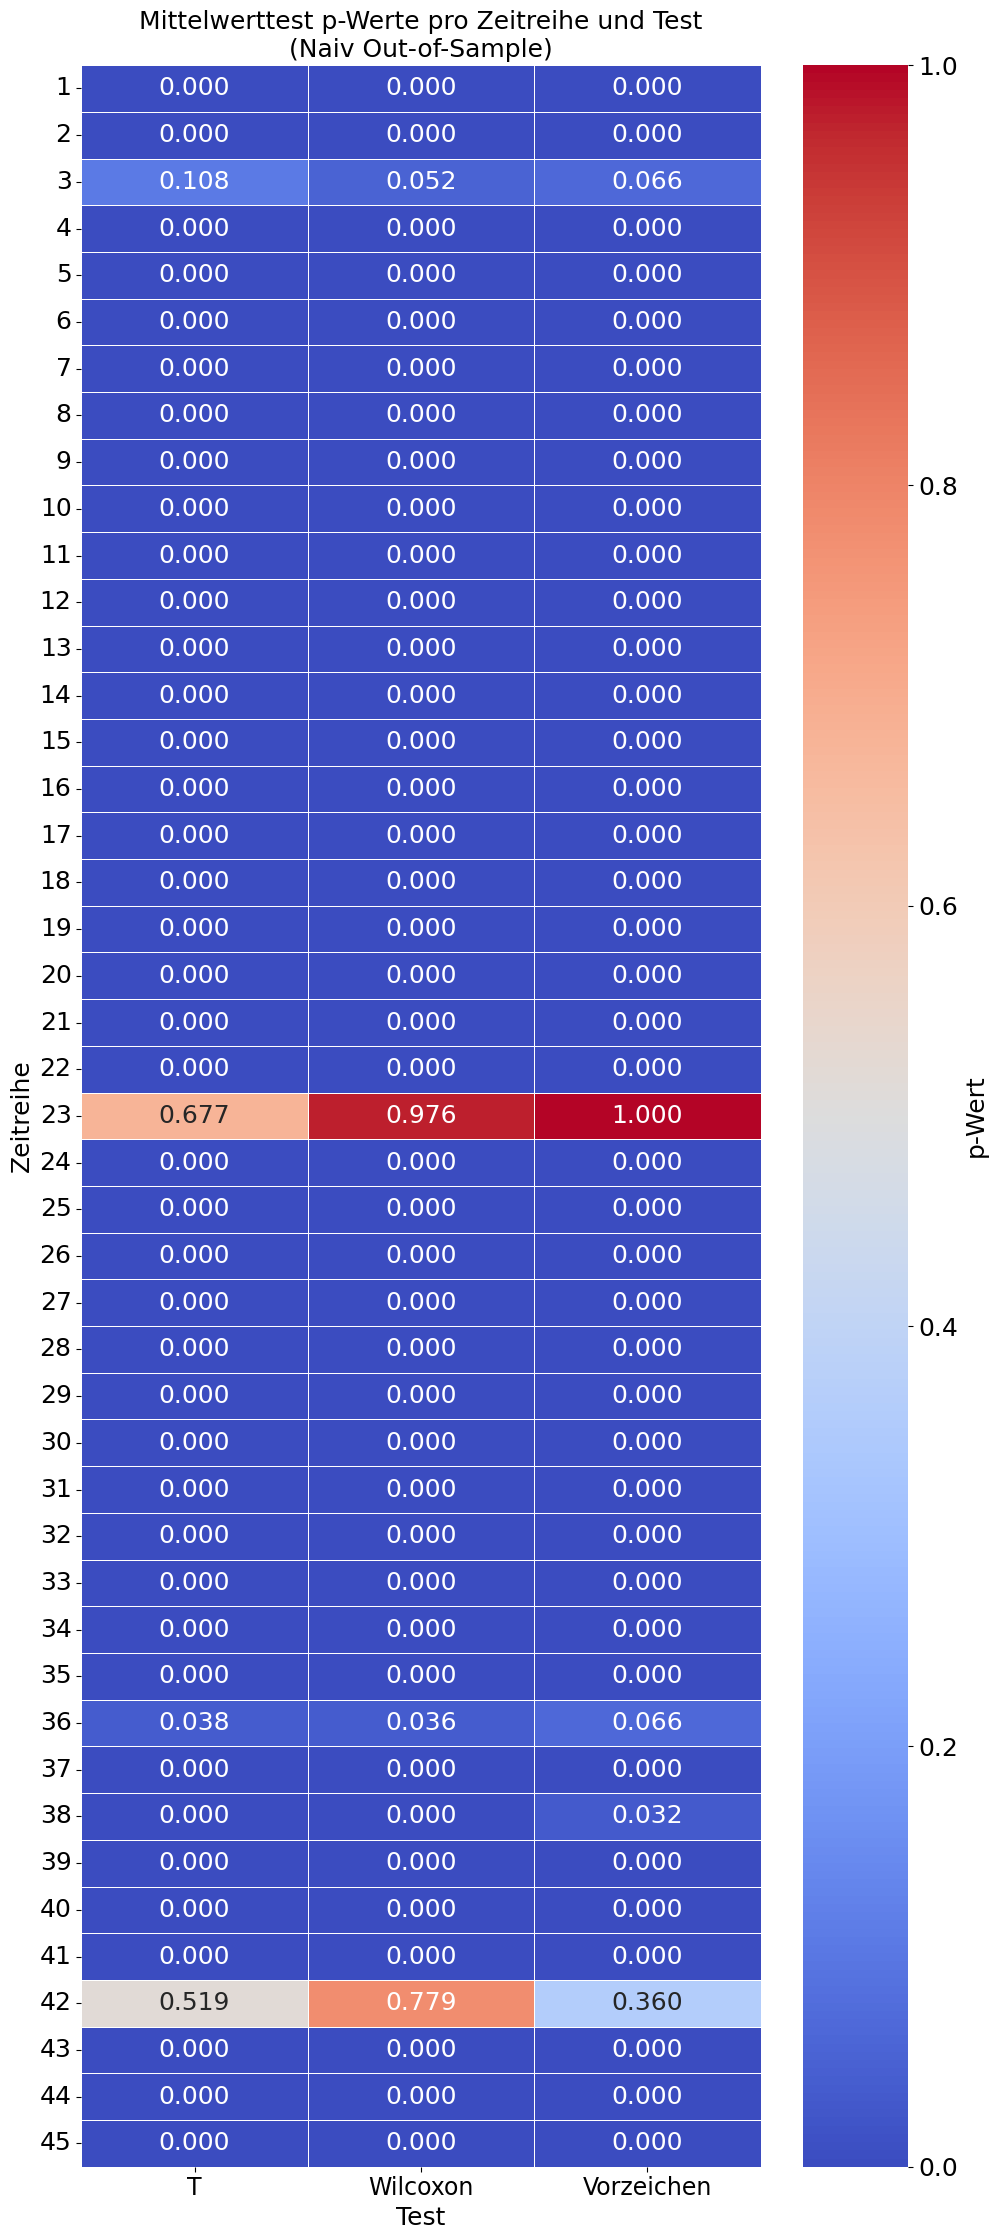

In [18]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []
z_pvalues = []
s_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = errors_dict.get(store)
    if errors is not None:
        # T-Test
        try:
            _, p_value = t_test(errors, False)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(errors, False)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(errors, False)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Sign Test
        try:
            _, s_value = vorzeichen_test(errors, False)
            s_pvalues.append(s_value)
        except Exception as e:
            print(f"Fehler beim Sign Test für Store {store}: {e}")
            s_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(errors, False)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
        # Z-Test
        try:
            _, p_value = z_test(errors, False)
            z_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Z-Test für Store {store}: {e}")
            z_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)
        z_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, s_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
meanprops = dict(marker='^',            # Dreieck
                 markerfacecolor="#00E034", # Füllfarbe
                 markeredgecolor='#00E034') # Randfarbe
plt.boxplot(pvalues, patch_artist=True, showmeans=True, meanprops=meanprops, medianprops=dict(color="#FF9D26"))
plt.title('Mittelwert p-Werte aller Zeitreihen (Naiv Out-of-Sample)')
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3], ["T-Test", "Wilcoxon", "Vorzeichen"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

print('T-TEST Mittelwert:', pd.Series(t_pvalues).mean(),
        'Median:', pd.Series(t_pvalues).median(),
        'Standardabweichung:', pd.Series(t_pvalues).std(),
        'Annahme (%):', (pd.Series(t_pvalues) >= 0.05).mean() * 100)

print('WILCOXON Mittelwert:', pd.Series(w_pvalues).mean(),
        'Median:', pd.Series(w_pvalues).median(),
        'Standardabweichung:', pd.Series(w_pvalues).std(),
        'Annahme (%):', (pd.Series(w_pvalues) >= 0.05).mean() * 100)

print('VORZEICHEN Mittelwert:', pd.Series(s_pvalues).mean(),
        'Median:', pd.Series(s_pvalues).median(),
        'Standardabweichung:', pd.Series(s_pvalues).std(),
        'Annahme (%):', (pd.Series(s_pvalues) >= 0.05).mean() * 100)


# Heatmap der p-Werte
store_names = [f"{i+1}" for i in range(pvalues.shape[0])]
columns = ["T", "Wilcoxon", "Vorzeichen"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)

plt.figure(figsize=(10, len(store_names) * 0.5))
ax = sns.heatmap(
    df_pvalues,
    annot=True,
    fmt=".3f",
    annot_kws={"size": 18},
    cmap="coolwarm",
    cbar_kws={'label': 'p-Wert'},
    vmin=0,
    vmax=1,
    linewidths=0.7,         # Breite der Linien zwischen den Zellen
    linecolor='white'     # Farbe der Linien
)

# Colorbar
cbar = ax.collections[0].colorbar
# Tick-Labels der Colorbar
cbar.ax.tick_params(labelsize=18)
# Label der Colorbar (p-Wert)
cbar.set_label('p-Wert', fontsize=18)
# Achsen-Tick-Labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=17)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18)
# Titel und Achsenbeschriftungen
plt.title(
    'Mittelwerttest p-Werte pro Zeitreihe und Test\n'
    '(Naiv Out-of-Sample)',
    fontsize=18
)
plt.xlabel("Test", fontsize=18)
plt.ylabel("Zeitreihe", fontsize=18)

plt.tight_layout()
plt.show()



SMAPE

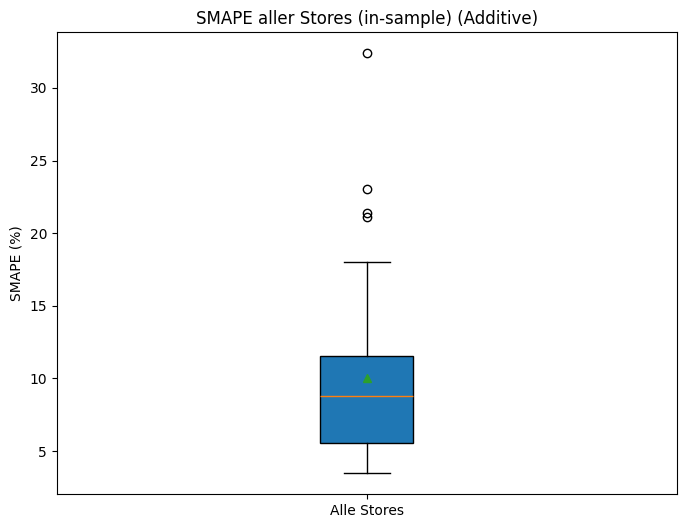

Mittelwert: 10.061110882195074 %
Median: 8.811175704332884 %
[4.50578755962276, 4.086493150896147, 4.0546608360299725, 5.167883386613283, 8.139300804839152, 5.529297348333985, 9.98527784047881, 6.1637437363705, 10.704872011670279, 11.160813815696036, 9.686485742543272, 16.520254875108694, 9.702845085788915, 23.040001062633127, 11.576970444475458, 14.888089043539798, 7.863487314050216, 8.443162405116645, 9.787052591758222, 8.811175704332884, 21.379013569136923, 18.021614423504413, 4.825770676936051, 9.625661757047324, 5.649432900924901, 7.1290399219900085, 14.242561162966513, 14.059497372915155, 14.285195062794179, 8.234420338152217, 10.852301373785084, 9.405171135098755, 8.217441684364871, 3.4730453646282924, 32.38059011195855, 5.428378617086913, 3.7181501786516824, 5.464495530073397, 10.0407404500104, 8.069173508069829, 12.193121138679116, 3.769056666217259, 7.034260093795199, 4.309176667482774, 21.125025232610454]


In [19]:
smape_stats = []

for store in range(1, 46):
    y_test = y_test_dict.get(store) # wahre Werte
    forecast = forecast_dict.get(store) # geschätzte Werte

    # SMAPE berechnen

    denom = (np.abs(y_test) + np.abs(forecast))
    # Vermeide Division durch 0
    mask = denom != 0
    smape = 100 * np.mean(2 * np.abs(forecast[mask] - y_test[mask]) / denom[mask])
    smape_stats.append(smape)

# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(smape_stats, patch_artist=True, showmeans=True)
plt.title(f'SMAPE aller Stores (in-sample) ({model_type})')
plt.ylabel("SMAPE (%)")
plt.xticks([1], ["Alle Stores"])
plt.show()

# Mittelwerte und Median der SMAPE Werte
print("Mittelwert:",np.mean(smape_stats), "%")
print("Median:",np.median(smape_stats), "%")
print(smape_stats)

SMAPE vs. Autokorrelation p-Werte

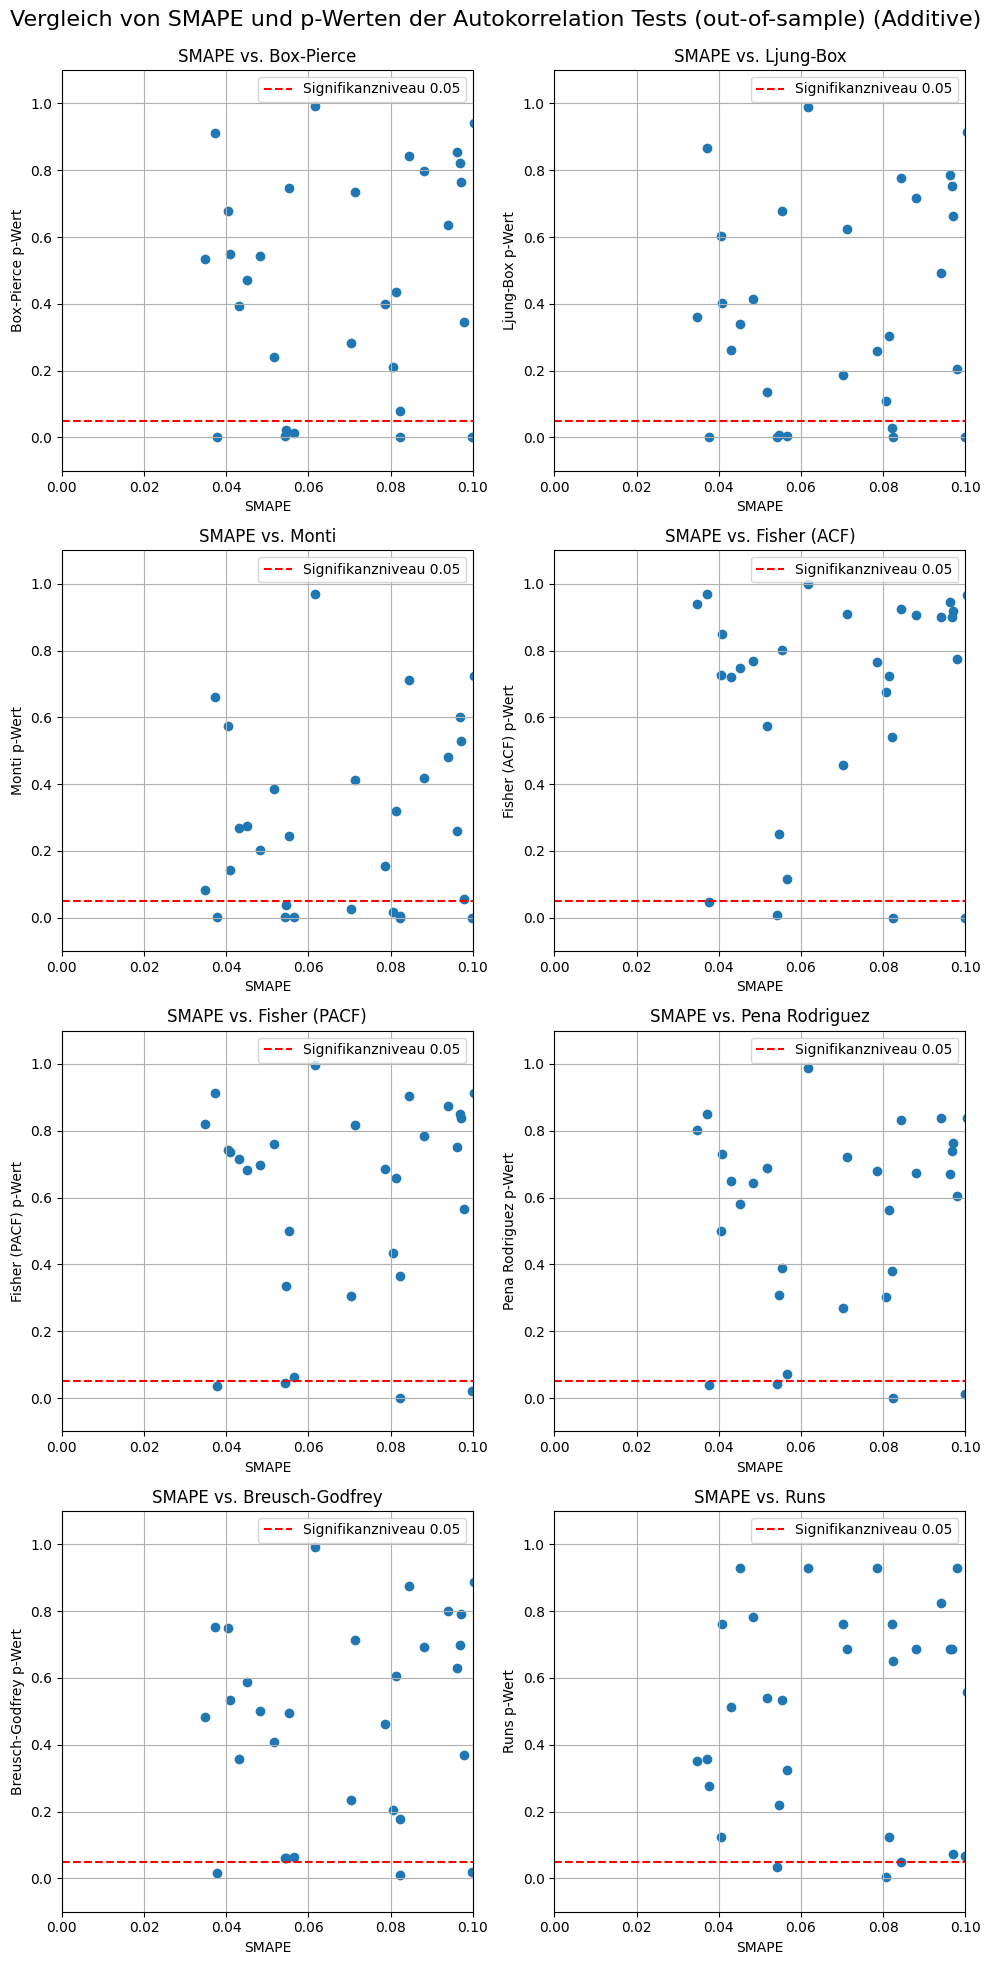

[[0.4720620978725666, 0.5502059415264007, 0.6776961127020014, 0.24171286383011076, 0.43638075399987614, 0.7469717377754805, 2.357255584289564e-06, 0.9934293458253665, 0.1651167660387807, 0.6803569283497075, 0.8213655436600253, 0.011596147937774684, 0.7659568159535433, 2.0136540717804086e-12, 0.5616209563740575, 1.0091086340911353e-05, 0.3989617504987213, 0.8430332479333323, 0.34530411048255655, 0.7978629876996719, 0.2642956159955594, 0.7257957181350223, 0.5418313580374059, 0.854364976880722, 0.012811560871649719, 0.7356021542875921, 0.6140634886231553, 0.0077779969066062975, 0.6309317393139171, 2.6893931533190304e-06, 0.6164067857044488, 0.6350606102350881, 0.08038051936242303, 0.5329893382333459, 1.1169683311423814e-08, 0.0033623487553896517, 0.9127090868038806, 0.023733856325751493, 0.9421695644824973, 0.21092187994361145, 0.54330396772262, 0.0020848062257479093, 0.2818171524268058, 0.39460583303681984, 0.8078458442846437], [0.33835782850883694, 0.403231220004803, 0.6018810844654683,

In [20]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))

smape_dec = np.asarray(smape_stats) / 100
p_values_list = [bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr_pvalues, bg_pvalues, rt_pvalues]
test_names = ["Box-Pierce", "Ljung-Box", "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez", "Breusch-Godfrey", "Runs"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_dec, p_values_list[i])
    ax.set_xlabel('SMAPE')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 0.1)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Autokorrelation Tests (out-of-sample) ({})'.format(model_type), fontsize=16)
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

print(p_values_list)

SMAPE vs. Mittelwert p-Werte

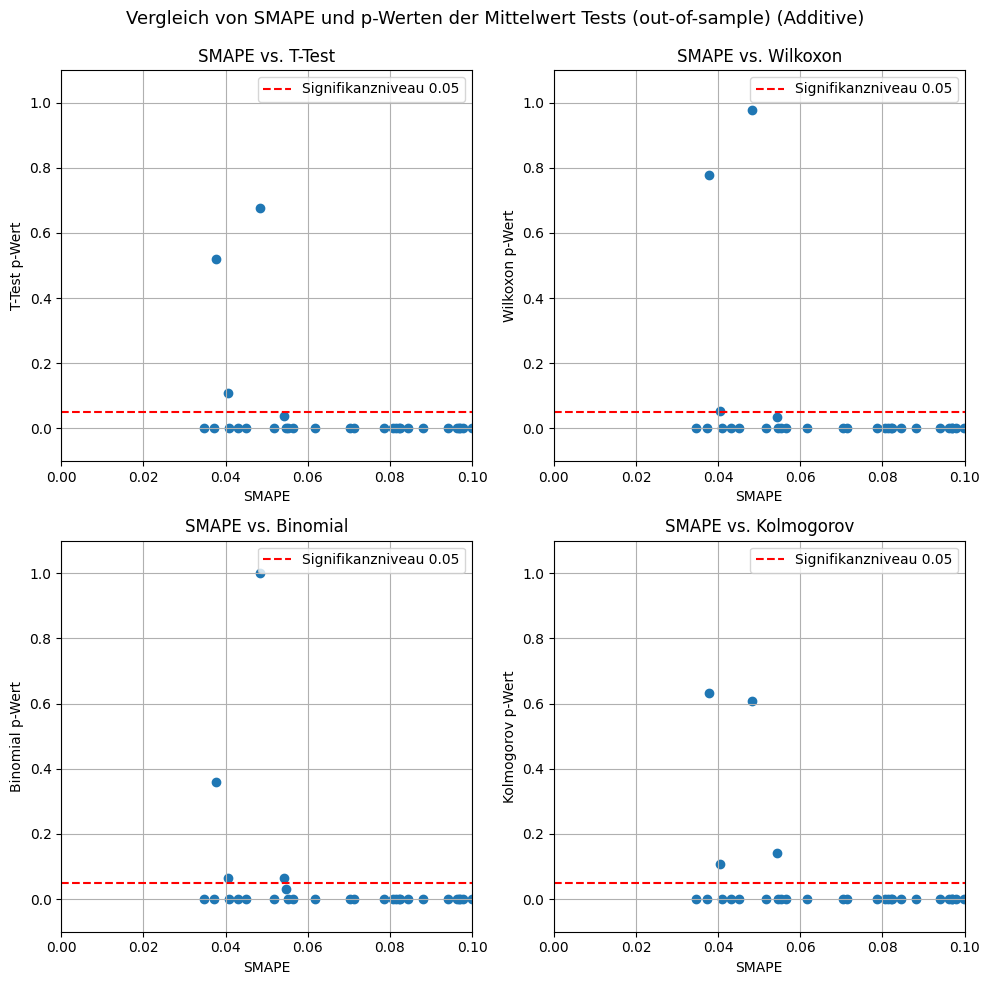

[[1.1588985653100945e-06, 7.928899280998324e-05, 0.10757713218009862, 1.3964117730984864e-10, 1.4156692742376068e-12, 1.0535079686423126e-08, 8.601793167811404e-14, 4.297888310950315e-14, 8.396540282763543e-19, 7.255861895203446e-19, 5.622914282702099e-15, 1.2467053055070984e-29, 9.05790705090121e-18, 1.2866473257835557e-18, 4.546054604762952e-16, 8.405599294719494e-22, 3.124922414606969e-17, 0.0001194515100680064, 1.3221472474288403e-15, 8.445313360849405e-11, 1.4968758748553997e-27, 9.384591486563504e-25, 0.6766169525357185, 1.7286808486461325e-14, 2.395811897276381e-07, 1.4907218916849957e-14, 8.92835095849943e-22, 1.2072811301682083e-14, 9.68748535352793e-19, 5.66650844574698e-12, 4.212866926614335e-28, 2.165028711956492e-21, 1.023880925142949e-15, 3.6721677828242057e-07, 4.269592680655452e-34, 0.038352033153370255, 8.196597760664439e-08, 0.00012990852229528168, 2.2426232003215027e-16, 1.876689023293912e-13, 7.629007300564637e-24, 0.5186273176838203, 3.134865342078065e-14, 4.887213

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

smape_dec = np.asarray(smape_stats) / 100
p_values_list = [t_pvalues, w_pvalues, b_pvalues, k_pvalues]
test_names = ["T-Test", "Wilkoxon", "Binomial", "Kolmogorov"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_dec, p_values_list[i])
    ax.set_xlabel('SMAPE')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 0.1)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Mittelwert Tests (out-of-sample) ({})'.format(model_type), fontsize=13)
plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

p_values_list_new = [t_pvalues, w_pvalues, s_pvalues]
print(p_values_list_new)